[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1uzUnRFR8tnSe5pTof-14fFbW91-kvcmp?usp=sharing)

# Environment setup

In [ ]:
# CUDA 11
# pip install onnxruntime-gpu

In [2]:
# CUDA 12
pip install onnxruntime-gpu --extra-index-url https://aiinfra.pkgs.visualstudio.com/PublicPackages/_packaging/onnxruntime-cuda-12/pypi/simple/

Looking in indexes: https://pypi.org/simple, https://aiinfra.pkgs.visualstudio.com/PublicPackages/_packaging/onnxruntime-cuda-12/pypi/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.9/192.9 MB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 982.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 1.8 MB/s eta 0:00:00


In [ ]:
# Download pretrained models, skip if you already downloaded the models
!mkdir ../data
!wget https://huggingface.co/dragonSwing/nanosam/resolve/main/sam_hgv2_b4_ln_nonorm_image_encoder.onnx -O ../data/sam_hgv2_b4_ln_nonorm_image_encoder.onnx
!wget https://huggingface.co/dragonSwing/nanosam/resolve/main/efficientvit_l0_mask_decoder.onnx -O ../data/efficientvit_l0_mask_decoder.onnx

# Inference

## Example image

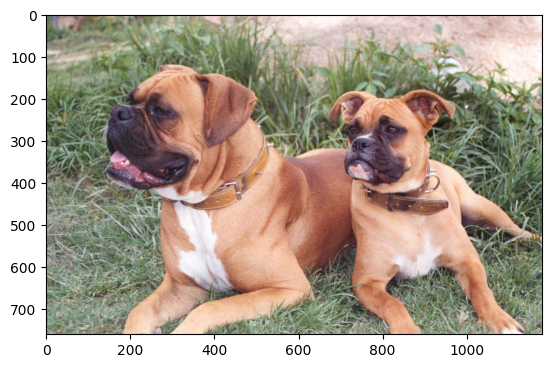

In [1]:
from nanosam.utils.predictor import Predictor
import PIL
import numpy as np
import matplotlib.pyplot as plt

image = PIL.Image.open("../assets/dogs.jpg")
plt.imshow(image)

In [2]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))


## ONNX

In [4]:
encoder_cfg = {
    "path": "../data/sam_hgv2_b4_ln_nonorm_image_encoder.onnx",
    "provider": "gpu",
    "normalize_input": False, # No ImageNet normalization
}
decoder_cfg = {
    "path": "../data/efficientvit_l0_mask_decoder.onnx",
    "provider": "gpu",
}
predictor = Predictor(encoder_cfg, decoder_cfg)

### Selecting object with SAM

Process the image to produce an image embedding by calling `Predictor.set_image`. `Predictor` remembers this embedding and will use it for subsequent mask prediction.

In [5]:
predictor.set_image(image)

To select the dog, choose a point on it. Points are input to the model in (x,y) format and come with labels 1 (foreground point) or 0 (background point). Multiple points can be input; here we use only one. The chosen point will be shown as a star on the image.

In [6]:
points = np.array([
    [500, 600],
])
point_labels = np.ones(points.shape[0])

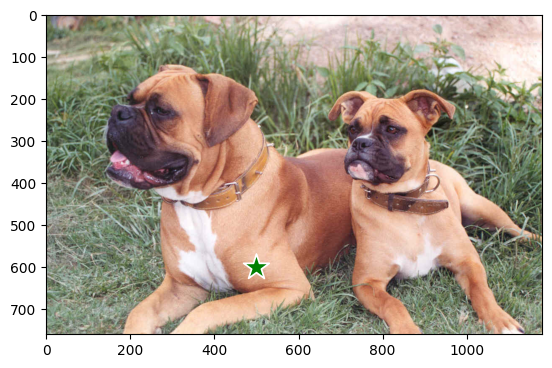

In [7]:
plt.imshow(image)
show_points(points, point_labels, plt.gca())
plt.show()

Predict with `Predictor.predict`. The model returns masks, quality predictions for those masks, and low resolution mask logits that can be passed to the next iteration of prediction.

In [8]:
masks, scores, logits = predictor.predict(
    points,
    point_labels,
)

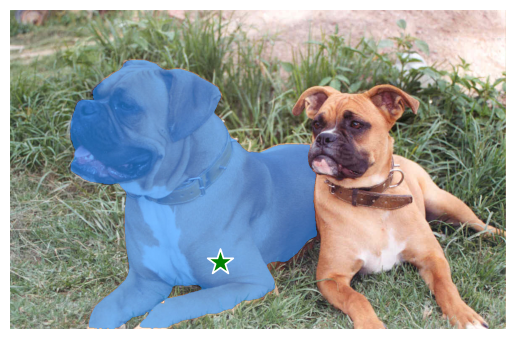

In [9]:
mask = (masks[0, 0] > 0)

plt.imshow(image)
show_mask(mask, plt.gca())
show_points(points, point_labels, plt.gca())
plt.axis('off')
plt.show()

### Specifying object using bounding box

The model can also take a box as input, provided in xyxy format.

In [10]:
bbox = [100, 100, 780, 759]  # x1, y1, x2, y2
box_points = np.array([
    [bbox[0], bbox[1]],
    [bbox[2], bbox[3]],
])
box_point_labels = np.array([2, 3])

In [11]:
masks, scores, logits = predictor.predict(
    box_points,
    box_point_labels,
)

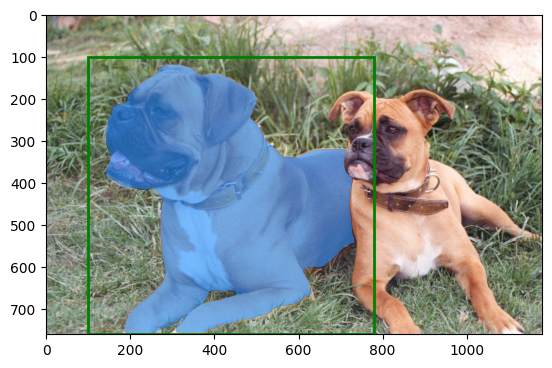

In [12]:
mask = (masks[0, 0] > 0)

plt.imshow(image)
show_mask(mask, plt.gca())
show_box(bbox, plt.gca())
plt.show()

## TensorRT

**Note**: If you want to use trtexec to build engines, please make sure to match the system TensorRT packages with Python TensorRT, or using Polygraphy for model conversion

For simplicity, I'll use Polygraphy for engine building in this example

In [ ]:
!pip install colored polygraphy --extra-index-url https://pypi.ngc.nvidia.com

In [13]:
# Skip if you already built the engine
!polygraphy convert ../data/efficientvit_l0_mask_decoder.onnx \
    -o ../data/efficientvit_l0_mask_decoder.engine \
    --trt-min-shapes point_coords:[1,1,2] point_labels:[1,1] \
    --trt-opt-shapes point_coords:[1,2,2] point_labels:[1,2] \
    --trt-max-shapes point_coords:[1,4,2] point_labels:[1,4] \
    --fp16

[W] onnx2trt_utils.cpp:374: Your ONNX model has been generated with INT64 weights, while TensorRT does not natively support INT64. Attempting to cast down to INT32.
[W] Tensor DataType is determined at build time for tensors not marked as input or output.
[I] Configuring with profiles:[
        Profile 0:
            {point_coords [min=[1, 1, 2], opt=[1, 2, 2], max=[1, 4, 2]],
             point_labels [min=[1, 1], opt=[1, 2], max=[1, 4]],
             image_embeddings [min=[1, 256, 64, 64], opt=[1, 256, 64, 64], max=[1, 256, 64, 64]],
             mask_input [min=[1, 1, 256, 256], opt=[1, 1, 256, 256], max=[1, 1, 256, 256]],
             has_mask_input [min=[1], opt=[1], max=[1]]}
    ]
[I] Building engine with configuration:
    Flags                  | [FP16]
    Engine Capability      | EngineCapability.DEFAULT
    Memory Pools           | [WORKSPACE: 15102.06 MiB, TACTIC_DRAM: 15102.06 MiB]
    Tactic Sources         | [CUBLAS, CUBLAS_LT, CUDNN, EDGE_MASK_CONVOLUTIONS, JIT_CONVOLU

In [2]:
# Skip if you already built the engine
!polygraphy convert ../data/sam_hgv2_b4_ln_nonorm_image_encoder.onnx \
        -o ../data/sam_hgv2_b4_ln_nonorm_image_encoder.engine \
        --fp16

[W] onnx2trt_utils.cpp:374: Your ONNX model has been generated with INT64 weights, while TensorRT does not natively support INT64. Attempting to cast down to INT32.
[I] Configuring with profiles:[
        Profile 0:
            {image [min=[1, 3, 512, 512], opt=[1, 3, 512, 512], max=[1, 3, 512, 512]]}
    ]
[I] Building engine with configuration:
    Flags                  | [FP16]
    Engine Capability      | EngineCapability.DEFAULT
    Memory Pools           | [WORKSPACE: 15102.06 MiB, TACTIC_DRAM: 15102.06 MiB]
    Tactic Sources         | [CUBLAS, CUBLAS_LT, CUDNN, EDGE_MASK_CONVOLUTIONS, JIT_CONVOLUTIONS]
    Profiling Verbosity    | ProfilingVerbosity.DETAILED
    Preview Features       | [FASTER_DYNAMIC_SHAPES_0805, DISABLE_EXTERNAL_TACTIC_SOURCES_FOR_CORE_0805]
[W] TensorRT encountered issues when converting weights between types and that could affect accuracy.
[W] If this is not the desired behavior, please modify the weights or retrain with regularization to adjust the magni

### Initialize predictor

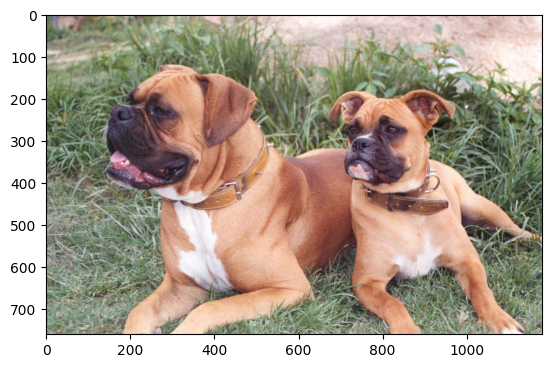

In [1]:
from nanosam.utils.predictor import Predictor
import PIL
import numpy as np
import matplotlib.pyplot as plt

image = PIL.Image.open("../assets/dogs.jpg")
plt.imshow(image)

In [2]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))


In [3]:
encoder_cfg = {
    "path": "../data/sam_hgv2_b4_ln_nonorm_image_encoder.engine",
    "name": "TrtModel",
    "input_names": ["image"],
    "output_names": ["image_embeddings"],
    "normalize_input": False,
}
decoder_cfg = {
    "path": "../data/efficientvit_l0_mask_decoder.engine",
    "name": "TrtModel",
    "input_names": ["image_embeddings", "point_coords", "point_labels", "mask_input", "has_mask_input"],
    "output_names": ["iou_predictions", "low_res_masks"],
}
predictor = Predictor(encoder_cfg, decoder_cfg)

In [4]:
predictor.set_image(image)

### Selecting object with SAM

In [5]:
points = np.array([
    [500, 600],
])
point_labels = np.ones(points.shape[0])

In [6]:
masks, scores, logits = predictor.predict(
    points,
    point_labels,
)

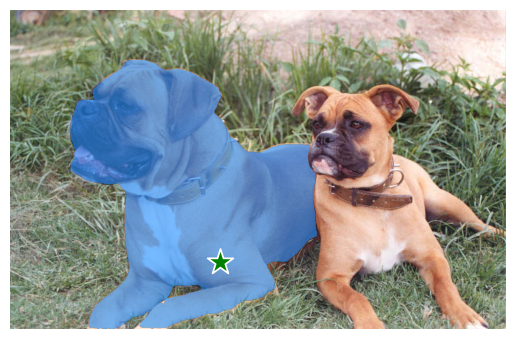

In [7]:
mask = (masks[0, 0] > 0)

plt.imshow(image)
show_mask(mask, plt.gca())
show_points(points, point_labels, plt.gca())
plt.axis('off')
plt.show()

### Specifying object using bounding box

In [8]:
bbox = [100, 100, 780, 759]  # x1, y1, x2, y2
box_points = np.array([
    [bbox[0], bbox[1]],
    [bbox[2], bbox[3]],
])
box_point_labels = np.array([2, 3])

In [9]:
masks, scores, logits = predictor.predict(
    box_points,
    box_point_labels,
)

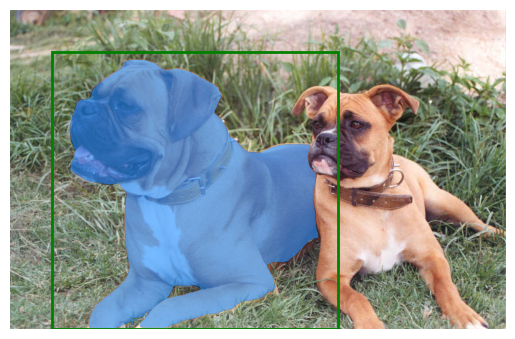

In [10]:
mask = (masks[0, 0] > 0)

plt.imshow(image)
show_mask(mask, plt.gca())
show_box(bbox, plt.gca())
plt.axis('off')
plt.show()